In [3]:
import matplotlib.pyplot as plt
import cv2 as cv
import scimage
import numpy as np
import random
import copy
from collections import namedtuple

In [2]:
!pip install scikit-image

In [4]:
from google.colab import drive
drive.mount('/content/drive')

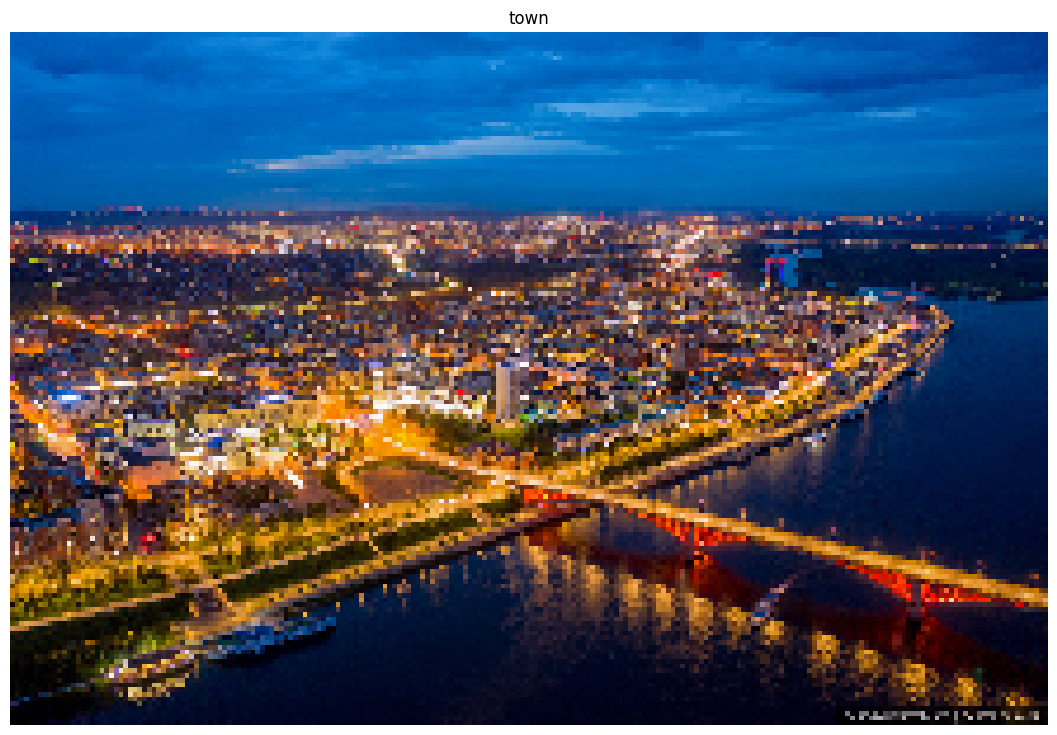

In [5]:
def draw_picture(image, title):
  b, g, r = cv.split(image)
  new_image = cv.merge([r, g, b])
  plt.figure(figsize=(16, 9))
  plt.axis('off')
  plt.imshow(new_image)
  plt.title(title)
  plt.show()

In [6]:
img = cv.imread('/content/drive/MyDrive/Colab Notebooks/cluster.png')
img = cv.resize(img, (220, 147))
draw_picture(img, 'town')

(32340, 3)

In [7]:
img = img.reshape(-1,3)
img.shape

In [8]:
def distribution(data, center, norm_ord = 2):
  content = [[] for _ in range(center.shape[0])]
  for index, vec in enumerate(data):
    min_dist = float('inf')
    min_k = -1
    for k, c in enumerate(center):
      dist = np.linalg.norm(vec - c, ord=norm_ord)
      if min_dist > dist:
        min_dist = dist
        min_k = k
    content[min_k].append((index, vec))
  return content

In [9]:
def cluster_update(data, content):
  new_center = []
  for vecs in content:
    new_center.append(np.mean(np.array(list(dict(vecs).values())), axis=0))
  return np.array(new_center)

In [10]:
def kmeans(data, k, norm_ord = 2):
  dim = data.shape[1]
  labels = np.zeros(data.shape[0])
  max_cluster_value = [data[:, col].max() for col in range(dim)]
  min_cluster_value = [data[:, col].min() for col in range(dim)]
  centers = np.array([[random.randint(min_cluster_value[i], max_cluster_value[i]) for i in range(dim)] for q in range(k)])
  content = distribution(data, centers)
  while 1:
    prev_centers = copy.deepcopy(centers)
    centers = cluster_update(data, content)
    content = distribution(data, centers, norm_ord)
    if prev_centers.all() == centers.all():
      break
  for i, vecs in enumerate(content):
    for j, _ in vecs:
      labels[j] = i
  t = namedtuple('comits', ['labels', 'centroids'])
  return t(labels, centers)

In [11]:
t = kmeans(img, 2)

array([[ 46.85720902,  50.12306053,  68.96600435],
       [173.56340125, 113.66396874,  42.86724346]])

In [12]:
t.centroids

In [13]:
d = dict(enumerate(t.centroids))

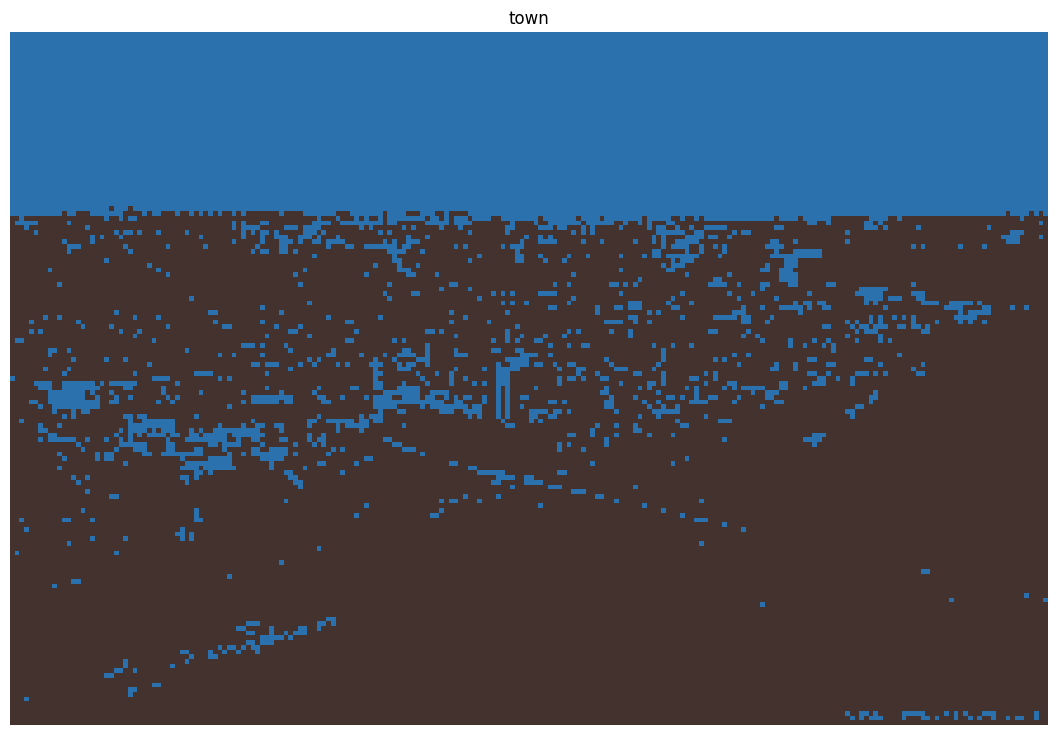

In [14]:
import pandas as pd
new_img = pd.Series(t.labels)
new_img = new_img.map(d)
new_img = new_img.to_list()
new_img = np.array(new_img)
new_img = new_img.reshape((147, 220, 3))

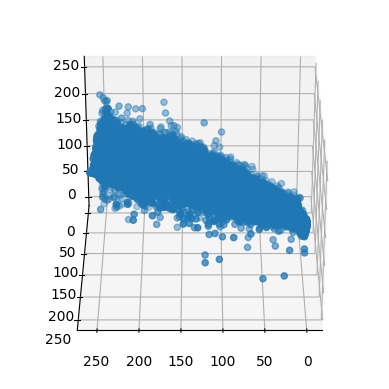

In [15]:
draw_picture(new_img.astype(int), 'town')

In [16]:
from mpl_toolkits.mplot3d import Axes3D
x = img[:, 2]
y = img[:, 0]
z = img[:, 1]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(30, 90)
ax.scatter3D(x, y, z, label='parametric curve')

In [17]:
def dbscan_naive(data, eps, m):
    P = [i for i in enumerate(data)]
    P = P[:100]

    NOISE = 0
    C = 0

    visited_points = set()
    clustered_points = set()
    clusters = {NOISE: []}

    def region_query(p):
      return [q for q in data if np.linalg.norm(q[1] - p[1]) <= eps]

    def expand_cluster(p, neighbours):
        if C not in clusters.keys():
            clusters[C] = []
        clusters[C].append(p)
        clustered_points.add(p[0])
        while neighbours:
            q = neighbours.pop()
            if q[0] not in visited_points:
                visited_points.add(q[0])
                neighbourz = region_query(q[1])
                if len(neighbourz) > m:
                    neighbours.extend(neighbourz)    
            if q[0] not in clustered_points:
              clustered_points.add(q[0])
              clusters[C].append(q)
              if q in clusters[NOISE]:
                  clusters[NOISE].remove(q)

    for p in P:
        if p[0] in visited_points:
            continue
        visited_points.add(p[0])
        neighbours = region_query(p)
        if len(neighbours) < m:
            clusters[NOISE].append(p)
        else:
            C += 1
            expand_cluster(p, neighbours)

    return clusters

In [86]:
def dbscan(dt, dist, m):
  data = [i for i in enumerate(dt)]
  data = data[:2000]

  clusters = {-1:[]}
  c = 0

  visited_points = set()

  def get_neighbors(p):
    return [q for q in data if np.linalg.norm(q[1] - p[1]) <= dist]

  def check_neighbors(p, neighbors):
    if c not  in clusters.keys():
      clusters[c] = []
    clusters[c].append(p)
    for q in neighbors:
      if q[0] not in visited_points:
        visited_points.add(q[0])
        clusters[c].append(q)
        if q in clusters[-1]:
          clusters[-1].remove(q)

  for p in data:
    if p[0] not in visited_points:
      visited_points.add(p[0])
    neighbors = get_neighbors(p)
    if len(neighbors) < m:
      clusters[-1].append(p)
    else:
      check_neighbors(p, neighbors)
      c+=1

  return clusters

In [106]:
db = dbscan_naive(img, 100, 1)

In [ ]:
last_d = {}
for i in db.keys():
  last_d[i] = []
  for row in db[i]:
    last_d[i].append(row[1])

In [107]:
db

{0: [(0, array([184,  94,   0], dtype=uint8)),
  (1, array([186,  96,   1], dtype=uint8)),
  (2, array([181,  89,   0], dtype=uint8)),
  (3, array([188,  97,   0], dtype=uint8)),
  (4, array([186,  93,   0], dtype=uint8)),
  (5, array([185,  92,   0], dtype=uint8)),
  (6, array([190,  99,   0], dtype=uint8)),
  (7, array([188,  98,   0], dtype=uint8)),
  (8, array([189,  95,   0], dtype=uint8)),
  (9, array([185,  96,   0], dtype=uint8)),
  (10, array([190,  99,   1], dtype=uint8)),
  (11, array([190,  99,   0], dtype=uint8)),
  (12, array([191, 101,   0], dtype=uint8)),
  (13, array([190,  99,   0], dtype=uint8)),
  (14, array([193, 105,   0], dtype=uint8)),
  (15, array([192, 102,   1], dtype=uint8)),
  (16, array([194, 102,   0], dtype=uint8)),
  (17, array([195, 107,   1], dtype=uint8)),
  (18, array([198, 108,   0], dtype=uint8)),
  (19, array([193, 101,   0], dtype=uint8)),
  (20, array([194, 102,   0], dtype=uint8)),
  (21, array([199, 110,   0], dtype=uint8)),
  (22, array([196